In [236]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [238]:
import tensorflow as tf

In [239]:
from agnfinder.tf_sampling import deep_emulator

In [240]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [242]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']
# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/mike/beta/agnfinder_results/uk_ir_selection_577_inc'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        f = h5py.File(galaxy_loc, mode='r')
#         print(f['is_accepted'][...].mean())
        if f['is_accepted'][...].mean() < 0.6:
            print(f['is_accepted'])
        else:
            galaxies.append({
                'samples': np.squeeze(f['samples'][::100]),
                'name': galaxy_loc.split('_')[-2],
                'true_observations': np.squeeze(f['true_observations'][...]),
                'redshift': f['redshift'][...],
                'uncertainty': f['uncertainty'][...]
            })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [243]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [244]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection_577.parquet')

In [245]:
# labels.columns.values

In [246]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

qso            150
starforming    150
passive        150
agn            107
starburst       20
Name: most_likely_rf_class, dtype: int64

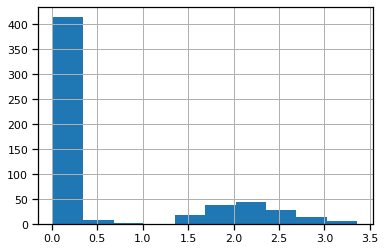

In [247]:
labels['redshift'].hist()

In [248]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
# label_dict

In [249]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]

In [250]:
# galaxy_locs

### How do we do at reproducing observations?

In [252]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [253]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])



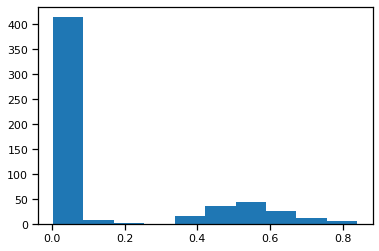

In [254]:
redshifts = np.array([g['redshift'] for g in galaxies]).squeeze()
_ = plt.hist(redshifts)

In [255]:
redshifts.shape

(571,)

In [256]:
import corner

In [257]:
galaxy['samples'].shape

(800, 8)

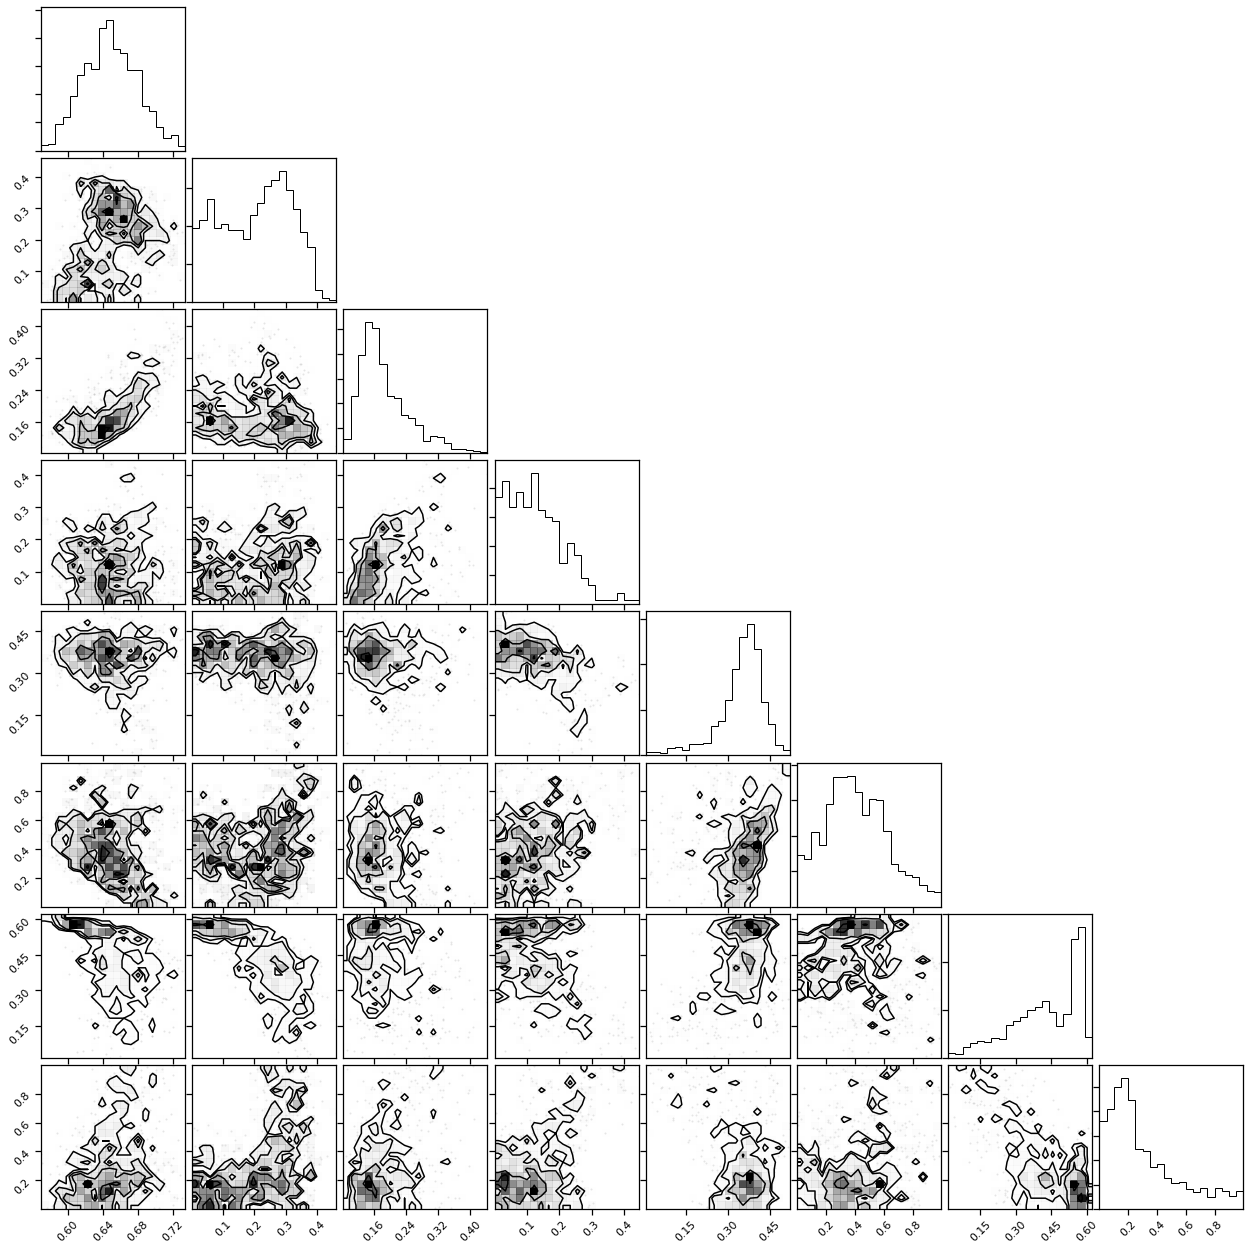

In [258]:
_ = corner.corner(galaxy['samples'])

In [259]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 0] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+', label=z)
# plt.legend()

In [260]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 1] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

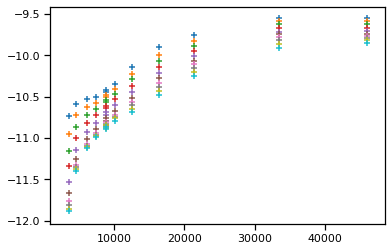

In [262]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, 2] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

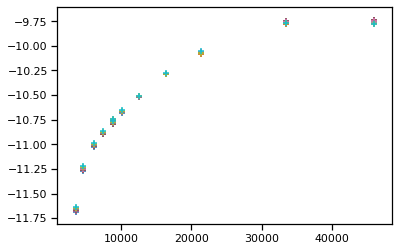

In [264]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, -1] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

In [265]:
list(zip(np.log10(galaxy['true_observations']), np.log10(galaxy['uncertainty'] / 5.)))

[(-7.778141, -9.141617),
 (-7.0569577, -9.278109),
 (-6.73202, -9.074944),
 (-6.5466084, -8.906845),
 (-6.4082923, -8.394046),
 (-6.1787624, -8.248589),
 (-6.2918277, -8.315001),
 (-6.1640153, -8.162403),
 (-6.3839574, -8.444721),
 (-6.4973063, -8.697152),
 (-6.406193, -8.063408),
 (-6.47028, -8.060549)]

In [273]:
def plot_galaxy(galaxy, ax, emulator, wavelengths):
    true_photometry = galaxy['true_observations']
    redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
#     print(redshifts.shape)
#     print(galaxy['samples'].shape)
    params_with_redshift = np.concatenate((redshifts, galaxy['samples']), axis=1)
#     print(params_with_redshift.shape)
    sample_photometry = deep_emulator.denormalise_photometry(emulator(params_with_redshift)).numpy()
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:500]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.02)
    ax.legend()
    ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [274]:
galaxy['rf_class']

'qso'

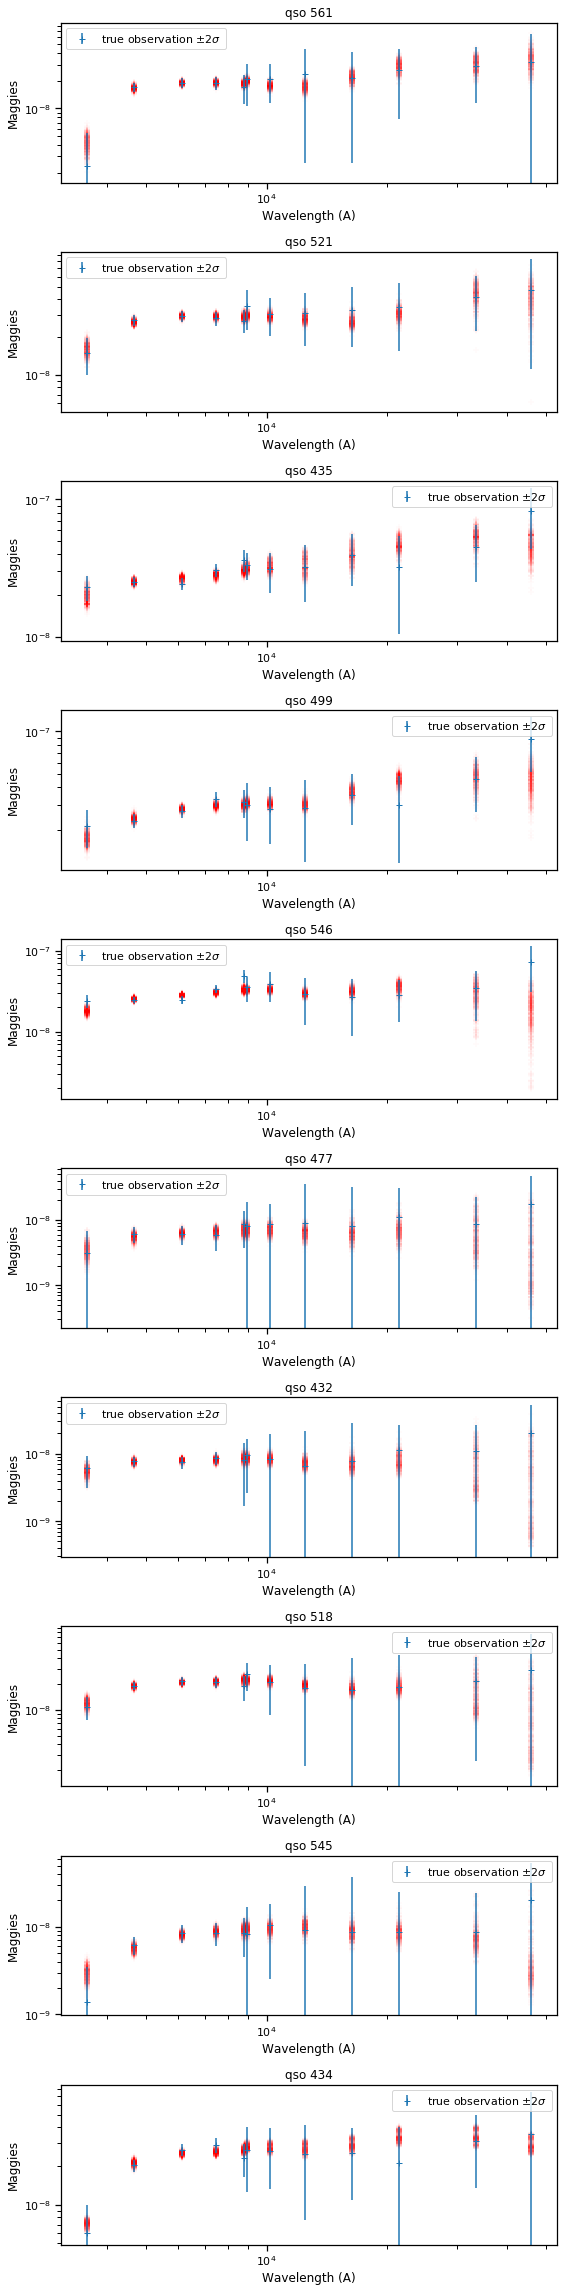

In [275]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    if galaxy['rf_class'] == 'qso':
        ax = axes[n]
        plot_galaxy(galaxy, ax, emulator, wavelengths)
        n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()

In [ ]:
galaxy['rf_class']

In [ ]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [ ]:
raw_df.head()

In [ ]:
len(raw_df)

In [ ]:
df = raw_df

In [ ]:
df['rf_class']

In [ ]:
df[params].median()

In [ ]:
(df[params] > 1e-3).shape

In [ ]:
df = df[np.all(df[params] > 1e-3, axis=1)]
df = df[np.all(df[params] < .999, axis=1)]

In [ ]:
df[params].min()

In [ ]:
df[params].max()

In [ ]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [ ]:
df['rf_class']

In [ ]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
#         print(values.shape)
        if len(values) > 0:
            sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

In [ ]:
# df = df[df['rf_class'] != 'agn']

In [ ]:
from agnfinder import simulation_utils
from collections import OrderedDict

# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())


In [ ]:
df['dust2'].hist()

In [ ]:
for galaxy in galaxies:
    galaxy['denormalised_samples'] = simulation_utils.denormalise_theta(galaxy['samples'], free_params)

In [ ]:
galaxy['samples'][0]

In [ ]:
galaxy['denormalised_samples'][0]

In [ ]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['denormalised_samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [ ]:
df = raw_df

In [ ]:
df[params].min()

In [ ]:
log_params = ['mass', 'tau', 'agn_disk_scaling', 'agn_torus_scaling']

In [ ]:
df['dust2'].hist()

In [ ]:
df = df.query('mass > 10 ** -5')  # a few masses are broken

In [ ]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
#     for galaxy_class in rf_classes:
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        if len(values) > 0:
            try:
                sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
            except ValueError:
                print('Failed {} {}'.format(feature, galaxy_class))
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')